In [1]:
import os
import albumentations as A
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

from dataset import PlantDataset

DATA_PATH = '../data/'


In [2]:
#training dataset
dataset_train = PlantDataset(set_dir='train').df
#testing dataset
dataset_valid = PlantDataset(set_dir='valid').df

# Mid-Level Fusion
### Extracting features with LBP: Local Binary Pattern

In [6]:
from skimage import io, feature
def ext_colored_features(path):
    # Load the image
    img = io.imread(path, as_gray=True)
    color_features = feature.local_binary_pattern(img, P=8, R=1.0, method='uniform')
    color_features = color_features.reshape((color_features.shape[0], -1))
    color_hist, _ = np.histogram(color_features.ravel(), bins=np.arange(0,27), range=(0,26))
    color_hist = color_hist.astype("float")
    color_hist /= (color_hist.sum() + 1e-7)
    return color_hist
    
def ext_side_features(path):
    # Load the image
    img = io.imread(path)
    side_features = feature.local_binary_pattern(img, P=8, R=1.0, method='uniform')
    side_features = side_features.reshape((side_features.shape[0], -1))
    side_hist, _ = np.histogram(side_features.ravel(), bins=np.arange(0,27), range=(0,26))
    side_hist = side_hist.astype("float")
    side_hist /= (side_hist.sum() + 1e-7)
    return side_hist

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier 

#divide instances into training and testing 
X_train = dataset_train[["color_cam_path","side_cam_path"]]
y_train = dataset_train["Label"]
X_test = dataset_valid[["color_cam_path","side_cam_path"]]
y_test = dataset_valid["Label"]

features_lbp_color_tr = []
features_lbp_side_tr = []
features_lbp_color_ts = []
features_lbp_side_ts = []

# features_lbp_color_tr= [ext_colored_features(DATA_PATH + path) for path in X_train["color_cam_path"]]

for path in X_train["color_cam_path"]:
    features_lbp_color_tr.append(ext_colored_features(DATA_PATH + path))
for path in X_train["side_cam_path"]:
    features_lbp_side_tr.append(ext_side_features(DATA_PATH + path))
for path in X_test["color_cam_path"]:
    features_lbp_color_ts.append(ext_colored_features(DATA_PATH + path))
for path in X_test["side_cam_path"]:
    features_lbp_side_ts.append(ext_side_features(DATA_PATH + path))

# Train KNN classifier
knn_color = KNeighborsClassifier(n_neighbors=5)
knn_color.fit(features_lbp_color_tr, y_train)

# Predict labels for test set
y_pred = knn_color.predict(features_lbp_color_ts)

# Evaluate classifier performance
accuracy_color = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_color)

# Train KNN classifier
knn_side = KNeighborsClassifier(n_neighbors=5)
knn_side.fit(features_lbp_side_tr, y_train)

# Predict labels for test set
y_pred = knn_side.predict(features_lbp_side_ts)

# Evaluate classifier performance
accuracy_side = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_side)

fused_features_tr = np.concatenate([features_lbp_color_tr, features_lbp_side_tr], axis=1)
fused_features_ts = np.concatenate([features_lbp_color_ts, features_lbp_side_ts], axis=1)
# Train KNN classifier
knn_fused = KNeighborsClassifier(n_neighbors=5)
knn_fused.fit(fused_features_tr, y_train)

# Predict labels for test set
y_pred = knn_fused.predict(fused_features_ts)

# Evaluate classifier performance
accuracy_fused = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_fused)

    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Accuracy: 0.8873239436619719
Accuracy: 0.9456740442655935
Accuracy: 0.954728370221328


### Extracting features with ORB

In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [140]:
#divide instances into training and testing
X_train = dataset_train[["color_cam_path","side_cam_path"]]
y_train = dataset_train["Label"]
X_test = dataset_valid[["color_cam_path","side_cam_path"]]
y_test = dataset_valid["Label"]

In [141]:
def ORB_color(paths):
    des_list = []
    orb = cv2.ORB_create()
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        des_list.append((paths[i], des))
    return des_list


def ORB_side(paths):
    des_list = []
    orb = cv2.ORB_create()
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        kp, des = orb.detectAndCompute(img, None)
        des_list.append((paths[i], des))
    return des_list

In [142]:
def feature_extraction(des_list):
    # Convert the features into a numpy array
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    # Convert into float
    descriptors_float = descriptors.astype(float)
    # Clustering the features
    centroids, variance = kmeans(descriptors_float, k_or_guess=25)
    # Create a histogram of features
    im_features = np.zeros((len(des_list), 25), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i][1], centroids)
        for w in words:
            im_features[i][w] += 1
    return im_features

def train_and_classify(im_features, labels):
    ### Scaling the features
    scaler = StandardScaler().fit(im_features)
    im_features = scaler.transform(im_features)

    # Classify the images
    clf = SVC(kernel='linear', C=1, probability=True, max_iter=100).fit(im_features, labels)
    return clf

# Evaluate the model
list_of_accuracy = []
def evaluate_model(y_test, y_predict, method, dataset, list_of_accuracy):
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
    plt.show()
    accuracy_description = f"The accuracy score of {method} with {dataset} is {accuracy_score(y_test, y_predict)}"
    list_of_accuracy.append(accuracy_description)
    for i in list_of_accuracy:
        print(i)

In [143]:
# Model training using ORB with color cam
descriptors_color_ORB = ORB_color(X_train['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_ORB = feature_extraction(descriptors_color_ORB)
clf_color_ORB = train_and_classify(features_color_ORB, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


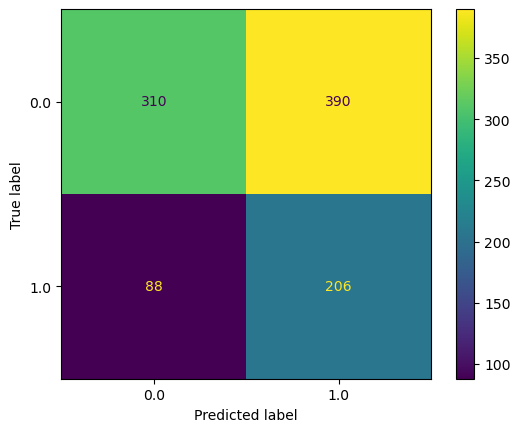

The accuracy score of ORB with color cam is 0.5191146881287726


In [144]:
# model evaluation
descriptors_color_test_ORB = ORB_color(X_test['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_test_ORB = feature_extraction(descriptors_color_test_ORB)
y_pred_color_ORB = clf_color_ORB.predict(features_color_test_ORB)
evaluate_model(y_test, y_pred_color_ORB, 'ORB', 'color cam', list_of_accuracy)

In [145]:
# Model training using ORB with side cam
descriptors_side_ORB = ORB_side(X_train['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_ORB = feature_extraction(descriptors_side_ORB)
clf_side_ORB = train_and_classify(features_side_ORB, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


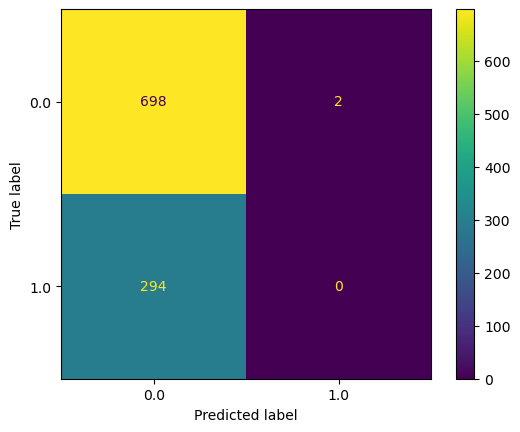

The accuracy score of ORB with color cam is 0.5191146881287726
The accuracy score of ORB with side cam is 0.7022132796780685


In [146]:
# model evaluation
descriptors_side_test_ORB = ORB_side(X_test['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_test_ORB = feature_extraction(descriptors_side_test_ORB)
y_pred_side_ORB = clf_side_ORB.predict(features_side_test_ORB)
evaluate_model(y_test, y_pred_side_ORB, 'ORB', 'side cam', list_of_accuracy)

### Extracting features with BRISK

In [147]:
def BRISK_color(paths):
    des_list = []
    brisk = cv2.BRISK_create(70, 4)
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = brisk.detectAndCompute(gray, None)
        des_list.append((paths[i], des))
    return des_list

def BRISK_side(paths):
    des_list = []
    brisk = cv2.BRISK_create(70, 4)
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        kp, des = brisk.detectAndCompute(img, None)
        des_list.append((paths[i], des))
    return des_list

In [148]:
# Model training using BRISK with color cam
descriptors_color_BRISK = BRISK_color(X_train['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_BRISK = feature_extraction(descriptors_color_BRISK)
clf_color_BRISK = train_and_classify(features_color_BRISK, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


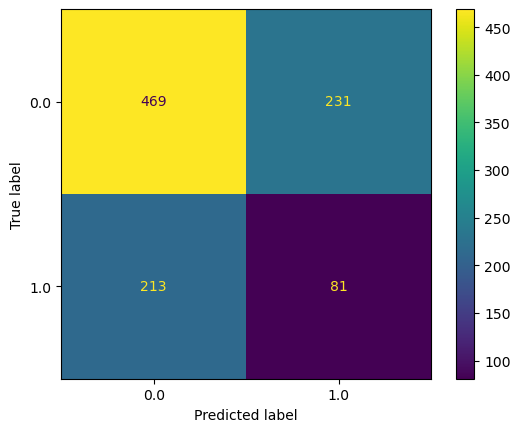

The accuracy score of ORB with color cam is 0.5191146881287726
The accuracy score of ORB with side cam is 0.7022132796780685
The accuracy score of BRISK with color cam is 0.5533199195171026


In [149]:
# model evaluation
descriptors_color_test_BRISK = BRISK_color(X_test['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_test_BRISK = feature_extraction(descriptors_color_test_BRISK)
y_pred_color_BRISK = clf_color_BRISK.predict(features_color_test_BRISK)
evaluate_model(y_test, y_pred_color_BRISK, 'BRISK', 'color cam', list_of_accuracy)

In [150]:
# Model training using BRISK with side cam
descriptors_side_BRISK = BRISK_side(X_train['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_BRISK = feature_extraction(descriptors_side_BRISK)
clf_side_BRISK = train_and_classify(features_side_BRISK, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


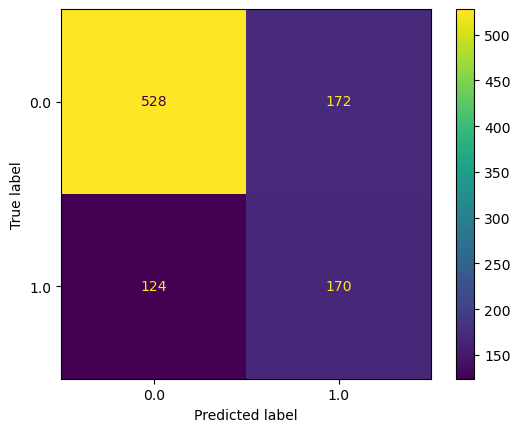

The accuracy score of ORB with color cam is 0.5191146881287726
The accuracy score of ORB with side cam is 0.7022132796780685
The accuracy score of BRISK with color cam is 0.5533199195171026
The accuracy score of BRISK with side cam is 0.7022132796780685


In [151]:
# Model evaluation
descriptors_side_test_BRISK = BRISK_side(X_test['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_test_BRISK = feature_extraction(descriptors_side_test_BRISK)
y_pred_side_BRISK = clf_side_BRISK.predict(features_side_test_BRISK)
evaluate_model(y_test, y_pred_side_BRISK, 'BRISK', 'side cam', list_of_accuracy)

### Extracting features with SIFT

In [152]:
def SIFT_color(paths):
    des_list = []
    sift = cv2.xfeatures2d.SIFT_create(200)
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        des_list.append((paths[i], des))
    return des_list

def SIFT_side(paths):
    des_list = []
    sift = cv2.xfeatures2d.SIFT_create(200)
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        kp, des = sift.detectAndCompute(img, None)
        des_list.append((paths[i], des))
    return des_list

In [153]:
# Model training using SIFT with color cam
descriptors_color_SIFT = SIFT_color(X_train['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_SIFT = feature_extraction(descriptors_color_SIFT)
clf_color_SIFT = train_and_classify(features_color_SIFT, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


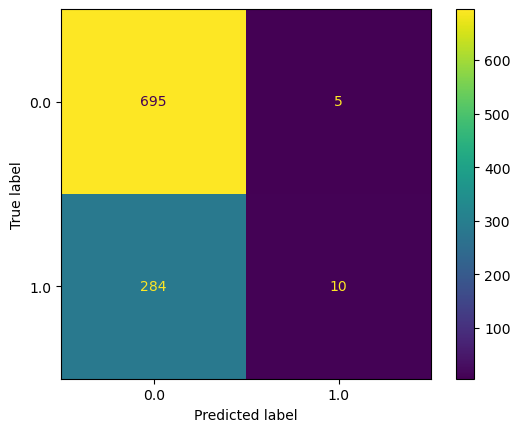

The accuracy score of ORB with color cam is 0.5191146881287726
The accuracy score of ORB with side cam is 0.7022132796780685
The accuracy score of BRISK with color cam is 0.5533199195171026
The accuracy score of BRISK with side cam is 0.7022132796780685
The accuracy score of SIFT with color cam is 0.7092555331991952


In [154]:
# Model evaluation
descriptors_color_test_SIFT = SIFT_color(X_test['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_test_SIFT = feature_extraction(descriptors_color_test_SIFT)
y_pred_color_SIFT = clf_color_SIFT.predict(features_color_test_SIFT)
evaluate_model(y_test, y_pred_color_SIFT, 'SIFT', 'color cam', list_of_accuracy)

In [155]:
# Model training using SIFT with side cam
descriptors_side_SIFT = SIFT_side(X_train['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_SIFT = feature_extraction(descriptors_side_SIFT)
clf_side_SIFT = train_and_classify(features_side_SIFT, y_train)

/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


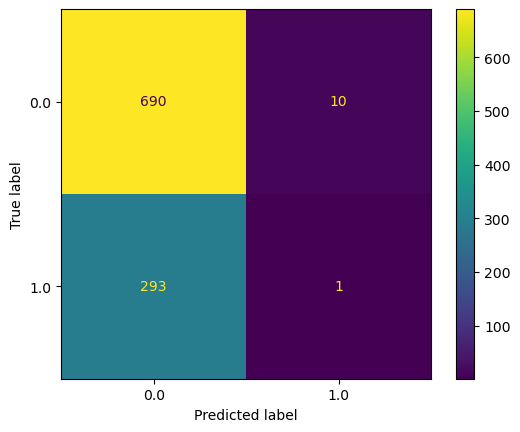

The accuracy score of ORB with color cam is 0.5191146881287726
The accuracy score of ORB with side cam is 0.7022132796780685
The accuracy score of BRISK with color cam is 0.5533199195171026
The accuracy score of BRISK with side cam is 0.7022132796780685
The accuracy score of SIFT with color cam is 0.7092555331991952
The accuracy score of SIFT with side cam is 0.6951710261569416


In [156]:
# Model evaluation
descriptors_side_test_SIFT = SIFT_side(X_test['side_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_side_test_SIFT = feature_extraction(descriptors_side_test_SIFT)
y_pred_side_SIFT = clf_side_SIFT.predict(features_side_test_SIFT)
evaluate_model(y_test, y_pred_side_SIFT, 'SIFT', 'side cam', list_of_accuracy)

### Result after data fusion

In [175]:
# features fusion
features_color_train = np.concatenate((features_color_ORB, features_color_BRISK, features_color_SIFT), axis=1)
features_side_train = np.concatenate((features_side_ORB, features_side_BRISK, features_side_SIFT), axis=1)
clf_color_fused = train_and_classify(features_color_train, y_train)
clf_side_fused = train_and_classify(features_side_train, y_train)
features_color_test = np.concatenate((features_color_test_ORB, features_color_test_BRISK, features_color_test_SIFT), axis=1)
features_side_test = np.concatenate((features_side_test_ORB, features_side_test_BRISK, features_side_test_SIFT), axis=1)
y_pred_color = clf_color_fused.predict(features_color_test)
y_pred_side = clf_side_fused.predict(features_side_test)
print(f"The accuracy score of color cam is {accuracy_score(y_test, y_pred_color)}")
print(f"The accuracy score of side cam is {accuracy_score(y_test, y_pred_side)}")

#model fusion
features_train = np.concatenate((features_color_train, features_side_train), axis=1)
features_test = np.concatenate((features_color_test, features_side_test), axis=1)
clf_fused = train_and_classify(features_train, y_train)
y_pred = clf_fused.predict(features_test)
print(f"The accuracy score of fused model is {accuracy_score(y_test, y_pred)}")

The accuracy score of color cam is 0.35110663983903423
The accuracy score of side cam is 0.306841046277666
The accuracy score of fused model is 0.45271629778672035


/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [174]:
# Feature fusion with weighted average
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
# Normalization
features_color_ORB_normalized = mmscaler.fit_transform(features_color_ORB)
features_color_BRISK_normalized = mmscaler.fit_transform(features_color_BRISK)
features_color_SIFT_normalized = mmscaler.fit_transform(features_color_SIFT)
features_side_ORB_normalized = mmscaler.fit_transform(features_side_ORB)
features_side_BRISK_normalized = mmscaler.fit_transform(features_side_BRISK)
features_side_SIFT_normalized = mmscaler.fit_transform(features_side_SIFT)

features_color_ORB_test_normalized = mmscaler.fit_transform(features_color_test_ORB)
features_color_BRISK_test_normalized = mmscaler.fit_transform(features_color_test_BRISK)
features_color_SIFT_test_normalized = mmscaler.fit_transform(features_color_test_SIFT)
features_side_ORB_test_normalized = mmscaler.fit_transform(features_side_test_ORB)
features_side_BRISK_test_normalized = mmscaler.fit_transform(features_side_test_BRISK)
features_side_SIFT_test_normalized = mmscaler.fit_transform(features_side_test_SIFT)

# weight for each feature
w_c_ORB = 0.25
w_c_BRISK = 0.25
w_c_SIFT = 0.5
w_s_ORB = 0.35
w_s_BRISK = 0.35
w_s_SIFT = 0.3

# weighted average training
features_color_train_weighted = w_c_ORB * features_color_ORB_normalized + w_c_BRISK * features_color_BRISK_normalized + w_c_SIFT * features_color_SIFT_normalized
features_side_train_weighted = w_s_ORB * features_side_ORB_normalized + w_s_BRISK * features_side_BRISK_normalized + w_s_SIFT * features_side_SIFT_normalized
clf_color_fused_weighted = train_and_classify(features_color_train_weighted, y_train)
clf_side_fused_weighted = train_and_classify(features_side_train_weighted, y_train)

features_color_test_weighted = w_c_ORB * features_color_test_ORB + w_c_BRISK * features_color_test_BRISK + w_c_SIFT * features_color_test_SIFT
features_side_test_weighted = w_s_ORB * features_side_test_ORB + w_s_BRISK * features_side_test_BRISK + w_s_SIFT * features_side_test_SIFT
y_pred_color_weighted = clf_color_fused_weighted.predict(features_color_test_weighted)
y_pred_side_weighted = clf_side_fused_weighted.predict(features_side_test_weighted)
print(f"The accuracy score of color cam is {accuracy_score(y_test, y_pred_color_weighted)}")
print(f"The accuracy score of side cam is {accuracy_score(y_test, y_pred_side_weighted)}")

# Fusion of two datasets
features_color_train_normalized = mmscaler.fit_transform(features_color_train_weighted)
features_side_train_normalized = mmscaler.fit_transform(features_side_train_weighted)
features_color_test_normalized = mmscaler.fit_transform(features_color_test_weighted)
features_side_test_normalized = mmscaler.fit_transform(features_side_test_weighted)

w_c = 0.4
w_s = 0.6
features_train_weighted = w_c * features_color_train_normalized + w_s * features_side_train_normalized
features_test_weighted = w_c * features_color_test_normalized + w_s * features_side_test_normalized
clf_fused_weighted = train_and_classify(features_train_weighted, y_train)
y_pred_weighted = clf_fused_weighted.predict(features_test_weighted)
print(f"The accuracy score of fused model is {accuracy_score(y_test, y_pred_weighted)}")

The accuracy score of color cam is 0.6991951710261569
The accuracy score of side cam is 0.7062374245472837
The accuracy score of fused model is 0.704225352112676


/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/guoyonghui/opt/anaconda3/envs/usual/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [159]:
# #cgray.cc
# #include <stream.h>
# #include <String.h>
# #include <stdlib.h>
# #include <math.h>
# void initab(int *, int, int);
# int cgray(int *, int *, int *, int *)
# int pos2(int *, int);
# int even(Jut);
# void fixepoint(int *, int,int,int);
# void affichetab(int *, int);
# int sometab(int *, int);
# // call of function cgray from Splus
# int cgray(int *x, int *point, int *n, int *k)
# {
# // calls :
# // pos2, fixepoint, affichage,initab, sommetab,even
# //
# int fini,b;
# fini=O;
# //first time round call with x=c(O,O,...O)
# if(sommetab(x,k)==O)
# {
# initab(x,k,O); //init of table to zero
# x[O]=n;
# //cout <<"\nfirst vector\t";
# affichetab(x,k);
# fixepoint(point,O,l,O); //fixes first (d,i,p)
# return(O);
# }
# if(x[k-1]==n)
# fini=l;
# if(point[2]==O)
# {
# b=pos2(x,k); //index of second non zero element
# if(b<=O)
# {
# //tout <<"erreur";
# return(-l);
# }
# if(b==l)
# { if((point[O]==O)~&(x[O]==l))
# fixepoint(point,O,1,1);
# }
# } //end p==O
# }
# else
# {
# if(even(n-x[O])) fixepoint
# (point,O,l,1);
# else if(!even(x[b])) fixepoint
# (point,O,b,b);
# else fixepoint(point,b,O,
# point[2]);